In [18]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

file_path = "Violence Against Women  Girls Data.csv"
df = pd.read_csv(file_path)

df['Survey Year'] = pd.to_datetime(df['Survey Year'], errors='coerce')
df['Year'] = df['Survey Year'].dt.year
df = df.drop(columns=['Survey Year'])

demo_pivot = df.pivot_table(
    index=['RecordID', 'Country', 'Gender', 'Year', 'Question'],
    columns='Demographics Question',
    values='Demographics Response',
    aggfunc='first'
).reset_index()

demo_pivot.columns.name = None
demo_pivot = demo_pivot.drop(columns=['Question'])

value_pivot = df.pivot_table(
    index=['RecordID', 'Country', 'Gender', 'Year'],
    columns='Question',
    values='Value',
    aggfunc='first'
).reset_index()

value_pivot.columns.name = None

full_df = pd.merge(
    demo_pivot, value_pivot,
    on=['RecordID', 'Country', 'Gender', 'Year'],
    how='left'
)

full_df = full_df.drop(columns=['RecordID', 'Year', 'Country'])

question_cols = value_pivot.columns[4:]  

full_df = full_df.fillna(0)

target_col = question_cols[0]
print(f"Target question: {target_col}")

y = (full_df[target_col] > 0).astype(int)

demographic_cols = ['Gender', 'Age', 'Education', 'Employment', 'Marital status', 'Residence']

X = full_df[demographic_cols]

print(X.head())
print(X.columns)
print(full_df.info())



Target question: ... for at least one specific reason
  Gender    Age     Education         Employment Marital status Residence
0      F  15-24        Higher  Employed for kind  Never married     Rural
1      M  25-34        Higher         Unemployed  Never married     Urban
2      F  15-24        Higher  Employed for cash  Never married     Urban
3      M  25-34  No education  Employed for cash  Never married     Rural
4      F  25-34        Higher         Unemployed  Never married     Urban
Index(['Gender', 'Age', 'Education', 'Employment', 'Marital status',
       'Residence'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 840 entries, 0 to 839
Data columns (total 12 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Gender                                   840 non-null    object 
 1   Age                                      840 non-null    object 
 2   

In [25]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), demographic_cols)
    ]
)

tree_model = ImbPipeline(steps=[
    ('preprocess', preprocessor),
    ('smote', SMOTE(random_state=42)),        
    ('classifier', DecisionTreeClassifier(
        max_depth=15,
        random_state=42
    ))
])

tree_model.fit(X_train, y_train)

y_pred = tree_model.predict(X_test)

print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

feature_names = tree_model.named_steps['preprocess'].get_feature_names_out()
importances = tree_model.named_steps['classifier'].feature_importances_

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importance (Demographics Only):")
print(importance_df.head(20))



Accuracy: 0.20476190476190476

Confusion Matrix:
 [[ 14 167]
 [  0  29]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.08      0.14       181
           1       0.15      1.00      0.26        29

    accuracy                           0.20       210
   macro avg       0.57      0.54      0.20       210
weighted avg       0.88      0.20      0.16       210


Feature Importance (Demographics Only):
                                             Feature  Importance
13                              cat__Residence_Rural    0.929361
10    cat__Marital status_Married or living together    0.066300
1                                      cat__Gender_M    0.004339
3                                     cat__Age_25-34    0.000000
4                                     cat__Age_35-49    0.000000
0                                      cat__Gender_F    0.000000
2                                     cat__Age_15-24    0.000000
6            

In [20]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), demographic_cols)
    ]
)

depth_values = [3, 5, 7, 10, 15]

results_list = []

for depth in depth_values:
    print(f"\n{'='*20} Decision Tree Depth: {depth} {'='*20}\n")

    tree_model = Pipeline(steps=[
        ('preprocess', preprocessor),
        ('classifier', DecisionTreeClassifier(
            max_depth=depth,
            class_weight='balanced',
            random_state=42
        ))
    ])
    
    tree_model.fit(X_train, y_train)

    y_pred = tree_model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    report_dict = classification_report(y_test, y_pred, output_dict=True)

    feature_names = tree_model.named_steps['preprocess'].get_feature_names_out()
    importances = tree_model.named_steps['classifier'].feature_importances_
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    print(f"Accuracy: {acc:.4f}")
    print("Confusion Matrix:\n", cm)
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("\nTop 10 Feature Importances:")
    print(importance_df.head(10))

    results_list.append({
        'Depth': depth,
        'Accuracy': acc,
        'Precision_0': report_dict['0']['precision'] if '0' in report_dict else np.nan,
        'Recall_0': report_dict['0']['recall'] if '0' in report_dict else np.nan,
        'F1_0': report_dict['0']['f1-score'] if '0' in report_dict else np.nan,
        'Support_0': report_dict['0']['support'] if '0' in report_dict else np.nan,
        'Precision_1': report_dict['1']['precision'] if '1' in report_dict else np.nan,
        'Recall_1': report_dict['1']['recall'] if '1' in report_dict else np.nan,
        'F1_1': report_dict['1']['f1-score'] if '1' in report_dict else np.nan,
        'Support_1': report_dict['1']['support'] if '1' in report_dict else np.nan,
        'Precision_2': report_dict['2']['precision'] if '2' in report_dict else np.nan,
        'Recall_2': report_dict['2']['recall'] if '2' in report_dict else np.nan,
        'F1_2': report_dict['2']['f1-score'] if '2' in report_dict else np.nan,
        'Support_2': report_dict['2']['support'] if '2' in report_dict else np.nan,
        'Top_Features': importance_df.head(5)['Feature'].tolist(),
        'Top_Importances': importance_df.head(5)['Importance'].tolist()
    })


results_df = pd.DataFrame(results_list)
print("\n\nSummary of Performance Measures for All Depths:")
print(results_df)



==================== Decision Tree Depth: 3 ====================

Accuracy: 0.2048
Confusion Matrix:
 [[ 14 167]
 [  0  29]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.08      0.14       181
           1       0.15      1.00      0.26        29

    accuracy                           0.20       210
   macro avg       0.57      0.54      0.20       210
weighted avg       0.88      0.20      0.16       210


Top 10 Feature Importances:
                                           Feature  Importance
13                            cat__Residence_Rural    0.914547
10  cat__Marital status_Married or living together    0.065243
1                                    cat__Gender_M    0.020210
3                                   cat__Age_25-34    0.000000
4                                   cat__Age_35-49    0.000000
0                                    cat__Gender_F    0.000000
2                                   cat__Age_15-24   

In [13]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from imblearn.over_sampling import SMOTENC
from imblearn.pipeline import Pipeline as ImbPipeline

file_path = "Violence Against Women  Girls Data.csv"
df = pd.read_csv(file_path)

df['Survey Year'] = pd.to_datetime(df['Survey Year'], errors='coerce')
df['Year'] = df['Survey Year'].dt.year
df = df.drop(columns=['Survey Year'])

demo_pivot = df.pivot_table(
    index=['RecordID', 'Country', 'Gender', 'Year', 'Question'],
    columns='Demographics Question',
    values='Demographics Response',
    aggfunc='first'
).reset_index()

demo_pivot.columns.name = None
demo_pivot = demo_pivot.drop(columns=['Question'])

value_pivot = df.pivot_table(
    index=['RecordID', 'Country', 'Gender', 'Year'],
    columns='Question',
    values='Value',
    aggfunc='first'
).reset_index()

value_pivot.columns.name = None

full_df = pd.merge(
    demo_pivot,
    value_pivot,
    on=['RecordID', 'Country', 'Gender', 'Year'],
    how='left'
)

full_df = full_df.drop(columns=['RecordID', 'Year', 'Country'])

question_cols = value_pivot.columns[4:]

full_df = full_df.fillna(0)

target_col = question_cols[0]
print(f"Target question: {target_col}")

def classify_three_levels(x):
    if x == 0:
        return 0  
    elif 0 < x <= 20:
        return 1  
    else:
        return 2 

y = full_df[target_col].apply(classify_three_levels)

demographic_cols = ['Gender', 'Age', 'Education', 'Employment', 'Marital status', 'Residence']
X = full_df[demographic_cols]

for col in demographic_cols:
    X[col] = X[col].astype('category')

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

categorical_idx = [X.columns.get_loc(col) for col in demographic_cols]

smote_nc = SMOTENC(
    categorical_features=categorical_idx,
    random_state=42
)

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), demographic_cols)
    ]
)

tree_model = ImbPipeline(steps=[
    ('preprocess', preprocessor),
    ('smote', smote_nc),
    ('classifier', DecisionTreeClassifier(
        max_depth=8,
        min_samples_leaf=3,
        class_weight='balanced',
        random_state=42
    ))
])

tree_model.fit(X_train, y_train)

y_pred = tree_model.predict(X_test)

print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

feature_names = tree_model.named_steps['preprocess'].get_feature_names_out()
importances = tree_model.named_steps['classifier'].feature_importances_

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\nTop 20 Important Demographic Predictors:")
print(importance_df.head(20))


Target question: ... for at least one specific reason

Accuracy: 0.14761904761904762

Confusion Matrix:
 [[15 78 85]
 [ 0  3  5]
 [ 0 11 13]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.08      0.16       178
           1       0.03      0.38      0.06         8
           2       0.13      0.54      0.20        24

    accuracy                           0.15       210
   macro avg       0.39      0.33      0.14       210
weighted avg       0.86      0.15      0.16       210


Top 20 Important Demographic Predictors:
                                             Feature  Importance
0                                      cat__Gender_F    0.889576
13                              cat__Residence_Rural    0.059121
14                              cat__Residence_Urban    0.051304
3                                     cat__Age_25-34    0.000000
4                                     cat__Age_35-49    0.000000
1                   

C:\Users\40723\AppData\Local\Temp\ipykernel_13216\4236540873.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype('category')
C:\Users\40723\AppData\Local\Temp\ipykernel_13216\4236540873.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype('category')
C:\Users\40723\AppData\Local\Temp\ipykernel_13216\4236540873.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

In [16]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from imblearn.over_sampling import SMOTENC
from imblearn.pipeline import Pipeline as ImbPipeline

file_path = "Violence Against Women  Girls Data.csv"
df = pd.read_csv(file_path)

df['Survey Year'] = pd.to_datetime(df['Survey Year'], errors='coerce')
df['Year'] = df['Survey Year'].dt.year
df = df.drop(columns=['Survey Year'])

demo_pivot = df.pivot_table(
    index=['RecordID','Country','Gender','Year','Question'],
    columns='Demographics Question',
    values='Demographics Response',
    aggfunc='first'
).reset_index()

demo_pivot.columns.name = None
demo_pivot = demo_pivot.drop(columns=['Question'])

value_pivot = df.pivot_table(
    index=['RecordID','Country','Gender','Year'],
    columns='Question',
    values='Value',
    aggfunc='first'
).reset_index()

value_pivot.columns.name = None

full_df = pd.merge(
    demo_pivot,
    value_pivot,
    on=['RecordID','Country','Gender','Year'],
    how='left'
)

full_df = full_df.drop(columns=['RecordID','Year','Country'])

question_cols = value_pivot.columns[4:]
demo_cols = ['Gender','Age','Education','Employment','Marital status','Residence']

full_df = full_df.fillna(0)

target_col = question_cols[0]

def classify_three_levels(x):
    if x == 0:
        return 0
    elif 0 < x <= 20:
        return 1
    else:
        return 2

y = full_df[target_col].apply(classify_three_levels)

predictors = demo_cols + [c for c in question_cols if c != target_col]
X = full_df[predictors]

for col in demo_cols:
    X[col] = X[col].astype("category")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

categorical_indices = [X.columns.get_loc(col) for col in demo_cols]

smote = SMOTENC(
    categorical_features=categorical_indices,
    random_state=42
)

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown='ignore'), demo_cols)
    ],
    remainder="passthrough"  
)

model = ImbPipeline(steps=[
    ("smote", smote),
    ("encode", preprocess),
    ("clf", DecisionTreeClassifier(
        max_depth=10,
        min_samples_leaf=4,
        class_weight="balanced",
        random_state=42
    ))
])

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

encoded_demo = model.named_steps['encode']\
                    .named_transformers_['cat']\
                    .get_feature_names_out(demo_cols)

passthrough_cols = [c for c in predictors if c not in demo_cols]

all_feature_names = list(encoded_demo) + passthrough_cols

importances = model.named_steps["clf"].feature_importances_

importance_df = pd.DataFrame({
    "Feature": all_feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

print("\nTop 20 Important Predictors:")
print(importance_df.head(20))


C:\Users\40723\AppData\Local\Temp\ipykernel_13216\454727070.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype("category")
C:\Users\40723\AppData\Local\Temp\ipykernel_13216\454727070.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype("category")
C:\Users\40723\AppData\Local\Temp\ipykernel_13216\454727070.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea


Accuracy: 0.8238095238095238

Confusion Matrix:
 [[157  19   2]
 [  0   3   5]
 [  0  11  13]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.88      0.94       178
           1       0.09      0.38      0.15         8
           2       0.65      0.54      0.59        24

    accuracy                           0.82       210
   macro avg       0.58      0.60      0.56       210
weighted avg       0.93      0.82      0.87       210


Top 20 Important Predictors:
                                        Feature  Importance
1                                      Gender_M    0.345247
16                    ... if she burns the food    0.160319
19      ... if she refuses to have sex with him    0.131800
15                   ... if she argues with him    0.127366
18             ... if she neglects the children    0.120547
17      ... if she goes out without telling him    0.114721
0                                      Gender_F 

C:\Users\40723\AppData\Local\Temp\ipykernel_13216\3423916777.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype("category")
C:\Users\40723\AppData\Local\Temp\ipykernel_13216\3423916777.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype("category")
C:\Users\40723\AppData\Local\Temp\ipykernel_13216\3423916777.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

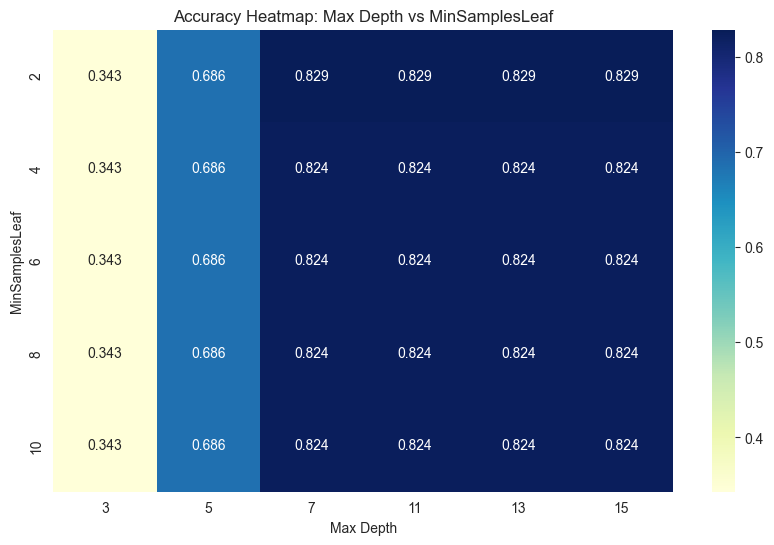


Detailed metrics table (Precision, Recall, F1 for each class):
 Depth  MinSamplesLeaf  Accuracy  Precision_0  Precision_1  Precision_2  Recall_0  Recall_1  Recall_2     F1_0     F1_1     F1_2
     3               2  0.342857          1.0     0.041096     0.160494  0.314607     0.375  0.541667 0.478632 0.074074 0.247619
     3               4  0.342857          1.0     0.041096     0.160494  0.314607     0.375  0.541667 0.478632 0.074074 0.247619
     3               6  0.342857          1.0     0.041096     0.160494  0.314607     0.375  0.541667 0.478632 0.074074 0.247619
     3               8  0.342857          1.0     0.041096     0.160494  0.314607     0.375  0.541667 0.478632 0.074074 0.247619
     3              10  0.342857          1.0     0.041096     0.160494  0.314607     0.375  0.541667 0.478632 0.074074 0.247619
     5               2  0.685714          1.0     0.068182     0.342105  0.719101     0.375  0.541667 0.836601 0.115385 0.419355
     5               4  0.685714 

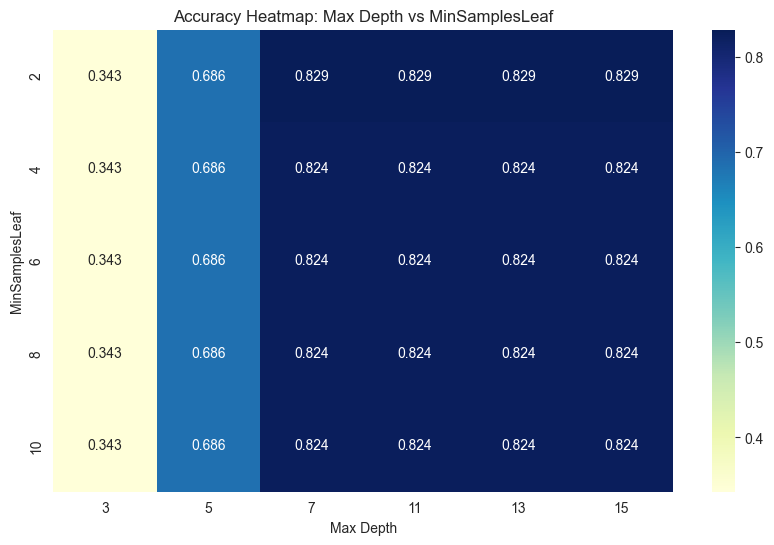

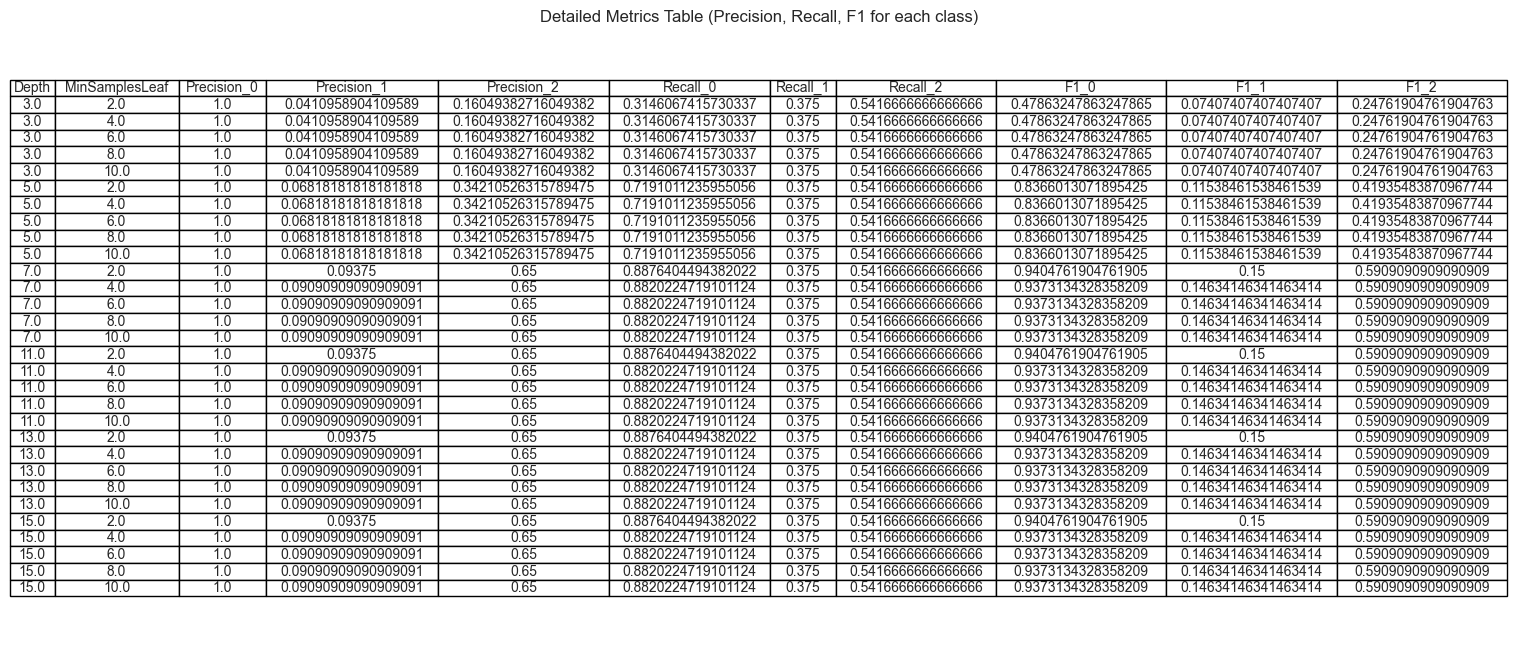

In [31]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

from imblearn.over_sampling import SMOTENC
from imblearn.pipeline import Pipeline as ImbPipeline

import matplotlib.pyplot as plt
import seaborn as sns

file_path = "Violence Against Women  Girls Data.csv"
df = pd.read_csv(file_path)

df['Survey Year'] = pd.to_datetime(df['Survey Year'], errors='coerce')
df['Year'] = df['Survey Year'].dt.year
df = df.drop(columns=['Survey Year'])

demo_pivot = df.pivot_table(
    index=['RecordID','Country','Gender','Year','Question'],
    columns='Demographics Question',
    values='Demographics Response',
    aggfunc='first'
).reset_index().drop(columns=['Question'])
value_pivot = df.pivot_table(
    index=['RecordID','Country','Gender','Year'],
    columns='Question',
    values='Value',
    aggfunc='first'
).reset_index()
full_df = pd.merge(demo_pivot, value_pivot, on=['RecordID','Country','Gender','Year'], how='left')
full_df = full_df.drop(columns=['RecordID','Year','Country']).fillna(0)

question_cols = value_pivot.columns[4:]
demo_cols = ['Gender','Age','Education','Employment','Marital status','Residence']
target_col = question_cols[0]

def classify_three_levels(x):
    if x == 0: return 0
    elif 0 < x <= 20: return 1
    else: return 2

y = full_df[target_col].apply(classify_three_levels)
predictors = demo_cols + [c for c in question_cols if c != target_col]
X = full_df[predictors]
for col in demo_cols:
    X[col] = X[col].astype("category")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

categorical_indices = [X.columns.get_loc(col) for col in demo_cols]
smote = SMOTENC(categorical_features=categorical_indices, random_state=42)
preprocess = ColumnTransformer(
    transformers=[("cat", OneHotEncoder(handle_unknown='ignore'), demo_cols)],
    remainder="passthrough"
)

depth_values = [3, 5, 7, 11, 13, 15]
leaf_values = [2, 4, 6, 8, 10]

results_list = []

for depth in depth_values:
    for leaf in leaf_values:
        model = ImbPipeline(steps=[
            ("smote", smote),
            ("encode", preprocess),
            ("clf", DecisionTreeClassifier(
                max_depth=depth,
                min_samples_leaf=leaf,
                class_weight="balanced",
                random_state=42
            ))
        ])
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        report_dict = classification_report(y_test, y_pred, output_dict=True)
        acc = accuracy_score(y_test, y_pred)
        
        results_list.append({
            "Depth": depth,
            "MinSamplesLeaf": leaf,
            "Accuracy": acc,
            "Precision_0": report_dict.get('0', {}).get('precision', np.nan),
            "Precision_1": report_dict.get('1', {}).get('precision', np.nan),
            "Precision_2": report_dict.get('2', {}).get('precision', np.nan),
            "Recall_0": report_dict.get('0', {}).get('recall', np.nan),
            "Recall_1": report_dict.get('1', {}).get('recall', np.nan),
            "Recall_2": report_dict.get('2', {}).get('recall', np.nan),
            "F1_0": report_dict.get('0', {}).get('f1-score', np.nan),
            "F1_1": report_dict.get('1', {}).get('f1-score', np.nan),
            "F1_2": report_dict.get('2', {}).get('f1-score', np.nan)
        })

results_df = pd.DataFrame(results_list)

accuracy_pivot = results_df.pivot(index='MinSamplesLeaf', columns='Depth', values='Accuracy')
plt.figure(figsize=(10,6))
sns.heatmap(accuracy_pivot, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("Accuracy Heatmap: Max Depth vs MinSamplesLeaf")
plt.ylabel("MinSamplesLeaf")
plt.xlabel("Max Depth")
plt.show()

metrics_cols = ['Depth','MinSamplesLeaf', 'Accuracy',
                'Precision_0','Precision_1','Precision_2',
                'Recall_0','Recall_1','Recall_2',
                'F1_0','F1_1','F1_2']
metrics_table = results_df[metrics_cols].sort_values(by=['Depth','MinSamplesLeaf'])
print("\nDetailed metrics table (Precision, Recall, F1 for each class):")
print(metrics_table.to_string(index=False))

accuracy_pivot = results_df.pivot(index='MinSamplesLeaf', columns='Depth', values='Accuracy')
plt.figure(figsize=(10,6))
sns.heatmap(accuracy_pivot, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("Accuracy Heatmap: Max Depth vs MinSamplesLeaf")
plt.ylabel("MinSamplesLeaf")
plt.xlabel("Max Depth")
plt.savefig("accuracy_heatmap.jpeg", dpi=300, bbox_inches='tight')  # Save heatmap
plt.show()


import matplotlib.backends.backend_agg as agg
from matplotlib.table import Table

metrics_cols = ['Depth','MinSamplesLeaf',
                'Precision_0','Precision_1','Precision_2',
                'Recall_0','Recall_1','Recall_2',
                'F1_0','F1_1','F1_2']
metrics_table = results_df[metrics_cols].sort_values(by=['Depth','MinSamplesLeaf'])

fig, ax = plt.subplots(figsize=(16,8))
ax.axis('tight')
ax.axis('off')
tbl = ax.table(cellText=metrics_table.values, colLabels=metrics_table.columns, cellLoc='center', loc='center')
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.auto_set_column_width(col=list(range(len(metrics_table.columns))))
plt.title("Detailed Metrics Table (Precision, Recall, F1 for each class)")
plt.savefig("metrics_table.jpeg", dpi=300, bbox_inches='tight')  # Save table as image
plt.show()



Modeling Question: ... for at least one specific reason
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.89      0.94       178
           1       0.09      0.38      0.15         8
           2       0.65      0.54      0.59        24

    accuracy                           0.83       210
   macro avg       0.58      0.60      0.56       210
weighted avg       0.93      0.83      0.87       210

Top 10 Features:
                                     Feature  Importance
1                                  Gender_M    0.341149
16                ... if she burns the food    0.158416
19  ... if she refuses to have sex with him    0.130236
15               ... if she argues with him    0.125854
18         ... if she neglects the children    0.119116
17  ... if she goes out without telling him    0.113359
14                          Residence_Urban    0.006614
2                                 Age_15-24    0.005254


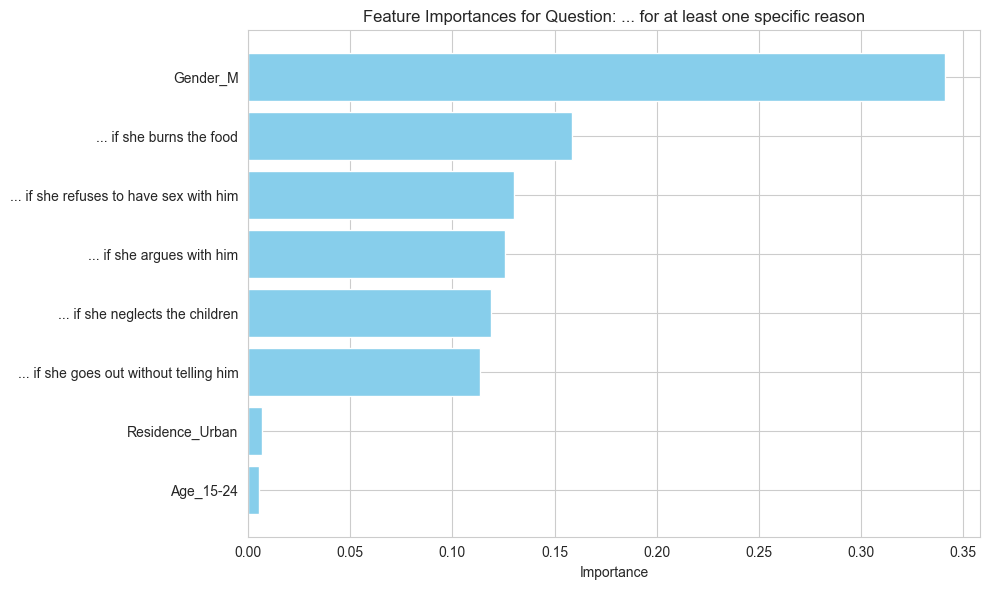


Modeling Question: ... if she argues with him


C:\Users\40723\anaconda3\envs\AMDAResearchReport1\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\40723\anaconda3\envs\AMDAResearchReport1\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\40723\anaconda3\envs\AMDAResearchReport1\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier,

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.98      0.96       179
           1       0.00      0.00      0.00        17
           2       0.38      0.57      0.46        14

    accuracy                           0.88       210
   macro avg       0.44      0.52      0.47       210
weighted avg       0.82      0.88      0.85       210

Top 10 Features:
                                     Feature  Importance
1                                  Gender_M    0.355485
16                ... if she burns the food    0.137484
19  ... if she refuses to have sex with him    0.130585
15     ... for at least one specific reason    0.124461
18         ... if she neglects the children    0.122513
17  ... if she goes out without telling him    0.119055
13                          Residence_Rural    0.009034
2                                 Age_15-24    0.001385


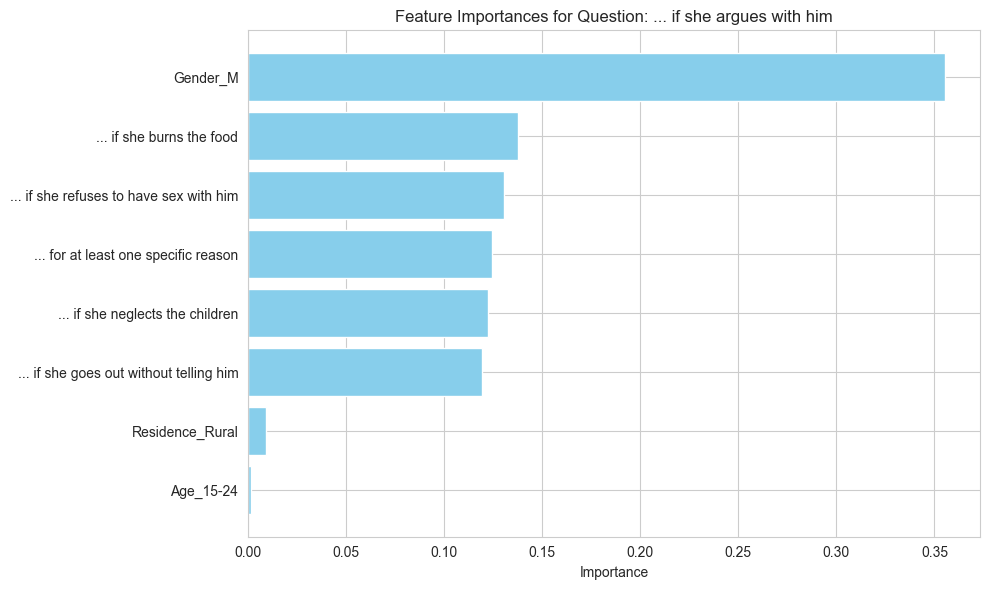


Modeling Question: ... if she burns the food
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.97       181
           1       0.73      0.42      0.54        26
           2       0.17      0.67      0.27         3

    accuracy                           0.90       210
   macro avg       0.62      0.69      0.59       210
weighted avg       0.93      0.90      0.91       210

Top 10 Features:
                                     Feature  Importance
1                                  Gender_M    0.319133
18         ... if she neglects the children    0.134679
19  ... if she refuses to have sex with him    0.131914
17  ... if she goes out without telling him    0.124935
16               ... if she argues with him    0.115281
15     ... for at least one specific reason    0.110300
14                          Residence_Urban    0.061028
7              Employment_Employed for cash    0.001979
3                          

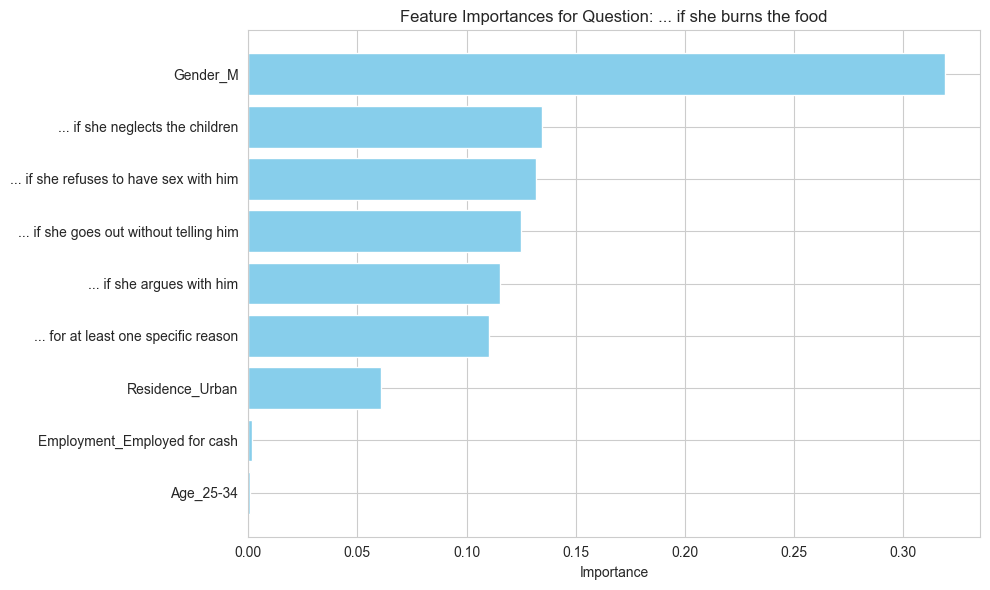


Modeling Question: ... if she goes out without telling him


C:\Users\40723\anaconda3\envs\AMDAResearchReport1\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\40723\anaconda3\envs\AMDAResearchReport1\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\40723\anaconda3\envs\AMDAResearchReport1\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier,

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.98      0.95       178
           1       0.00      0.00      0.00        18
           2       0.45      0.64      0.53        14

    accuracy                           0.88       210
   macro avg       0.46      0.54      0.49       210
weighted avg       0.81      0.88      0.84       210

Top 10 Features:
                                       Feature  Importance
1                                    Gender_M    0.343449
17                  ... if she burns the food    0.140857
16                 ... if she argues with him    0.134634
19    ... if she refuses to have sex with him    0.130941
15       ... for at least one specific reason    0.123040
18           ... if she neglects the children    0.116571
14                            Residence_Urban    0.009070
10  Marital status_Married or living together    0.001439


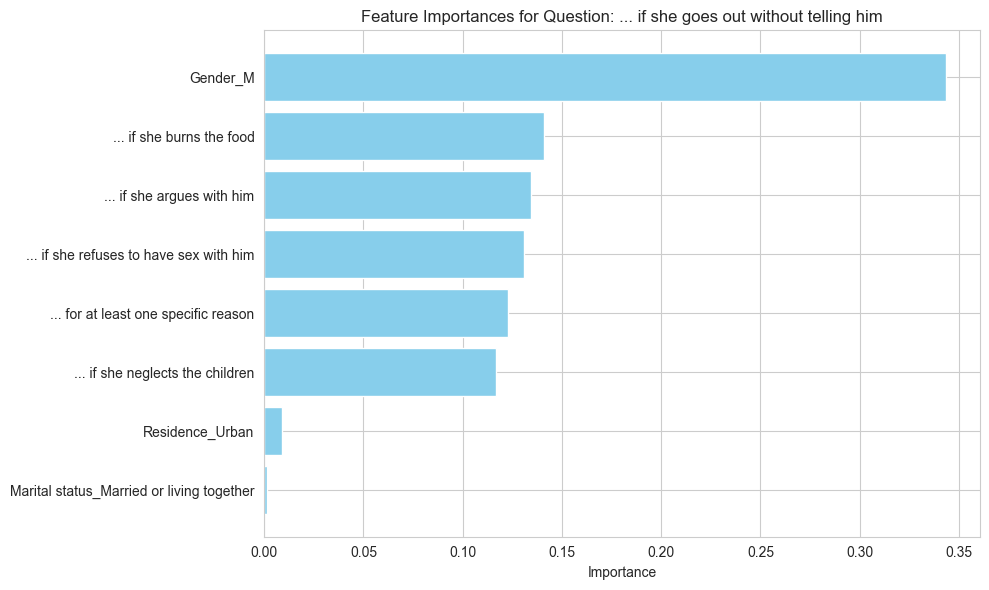


Modeling Question: ... if she neglects the children
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.92      0.96       178
           1       0.26      0.54      0.35        13
           2       0.55      0.58      0.56        19

    accuracy                           0.86       210
   macro avg       0.60      0.68      0.62       210
weighted avg       0.91      0.86      0.88       210

Top 10 Features:
                                     Feature  Importance
1                                  Gender_M    0.347378
19  ... if she refuses to have sex with him    0.150881
17                ... if she burns the food    0.144133
16               ... if she argues with him    0.119131
15     ... for at least one specific reason    0.118994
18  ... if she goes out without telling him    0.107681
13                          Residence_Rural    0.006589
14                          Residence_Urban    0.005213


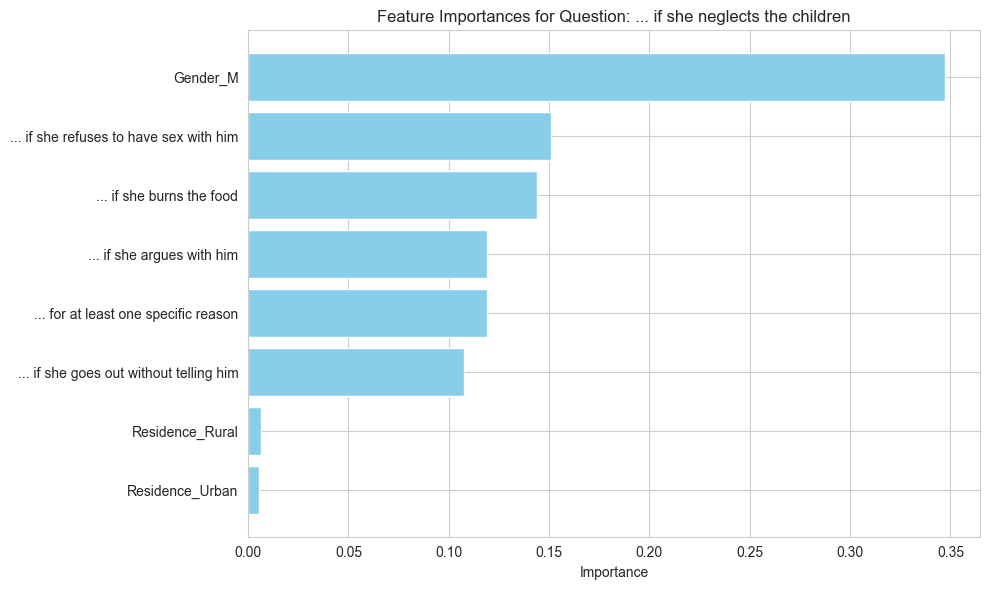


Modeling Question: ... if she refuses to have sex with him
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.86      0.92       179
           1       0.40      0.67      0.50        24
           2       0.31      0.71      0.43         7

    accuracy                           0.83       210
   macro avg       0.57      0.75      0.62       210
weighted avg       0.91      0.83      0.86       210

Top 10 Features:
                                     Feature  Importance
1                                  Gender_M    0.342682
17                ... if she burns the food    0.157484
19         ... if she neglects the children    0.127237
16               ... if she argues with him    0.125194
15     ... for at least one specific reason    0.122898
18  ... if she goes out without telling him    0.112830
14                          Residence_Urban    0.011676


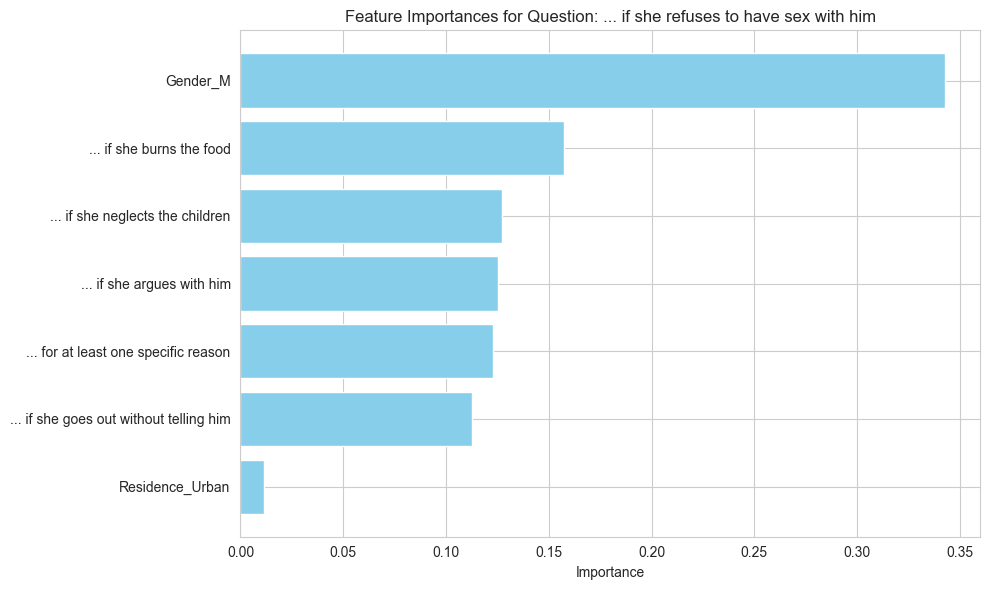

In [33]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from imblearn.over_sampling import SMOTENC
from imblearn.pipeline import Pipeline as ImbPipeline

file_path = "Violence Against Women  Girls Data.csv"
df = pd.read_csv(file_path)

df['Survey Year'] = pd.to_datetime(df['Survey Year'], errors='coerce')
df['Year'] = df['Survey Year'].dt.year
df = df.drop(columns=['Survey Year'])

demo_pivot = df.pivot_table(
    index=['RecordID','Country','Gender','Year','Question'],
    columns='Demographics Question',
    values='Demographics Response',
    aggfunc='first'
).reset_index().drop(columns=['Question'])

value_pivot = df.pivot_table(
    index=['RecordID','Country','Gender','Year'],
    columns='Question',
    values='Value',
    aggfunc='first'
).reset_index()

full_df = pd.merge(demo_pivot, value_pivot, on=['RecordID','Country','Gender','Year'], how='left')
full_df = full_df.drop(columns=['RecordID','Year','Country']).fillna(0)

question_cols = value_pivot.columns[4:]
demo_cols = ['Gender','Age','Education','Employment','Marital status','Residence']

for col in demo_cols:
    full_df[col] = full_df[col].astype('category')

def classify_three_levels(x):
    if x == 0: return 0
    elif 0 < x <= 20: return 1
    else: return 2

results = {}

for target_col in question_cols:
    print(f"\n{'='*30}\nModeling Question: {target_col}\n{'='*30}")

    y = full_df[target_col].apply(classify_three_levels)

    predictors = demo_cols + [c for c in question_cols if c != target_col]
    X = full_df[predictors]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42, stratify=y
    )

    categorical_indices = [X.columns.get_loc(col) for col in demo_cols]
    smote = SMOTENC(categorical_features=categorical_indices, random_state=42)

    preprocess = ColumnTransformer(
        transformers=[("cat", OneHotEncoder(handle_unknown='ignore'), demo_cols)],
        remainder='passthrough'
    )

    model = ImbPipeline(steps=[
        ("smote", smote),
        ("encode", preprocess),
        ("clf", DecisionTreeClassifier(
            max_depth=7,
            min_samples_leaf=2,
            class_weight='balanced',
            random_state=42
        ))
    ])

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    print("Classification Report:\n", classification_report(y_test, y_pred))

    encoded_demo = model.named_steps['encode'].named_transformers_['cat'].get_feature_names_out(demo_cols)
    passthrough_cols = [c for c in predictors if c not in demo_cols]
    all_feature_names = list(encoded_demo) + passthrough_cols
    importances = model.named_steps['clf'].feature_importances_
    
    importance_df = pd.DataFrame({
        'Feature': all_feature_names,
        'Importance': importances
    })
    
    importance_df = importance_df[importance_df['Importance'] > 0].sort_values(by='Importance', ascending=False)
    
    print("Top 10 Features:\n", importance_df.head(10))
 
    results[target_col] = {
        'classification_report': classification_report(y_test, y_pred, output_dict=True),
        'feature_importances': importance_df
    }

    plt.figure(figsize=(10,6))
    plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
    plt.gca().invert_yaxis() 
    plt.xlabel('Importance')
    plt.title(f'Feature Importances for Question: {target_col}')
    plt.tight_layout()
    plt.savefig(f'feature_importances_{target_col}.jpeg', dpi=300, bbox_inches='tight')
    plt.show()